# The first method is the mean crossing rule of warm-up period estimation

In [1]:
# Investigate steady state condition
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
mean_service_holding_time = 25
arrival_rate = 10
load = mean_service_holding_time*arrival_rate
num_requests = 100000

results = []
for repeats in range(1000):
    for load in np.arange(50,1050,50):
        for arrival_rate in [5, 10, 15, 20, 25]:
            mean_service_holding_time = load/arrival_rate
            services = []
            active_services = []
            current_time = 0
            for i in range(num_requests):
                current_time += np.random.exponential(1/arrival_rate)
                holding_time = np.random.exponential(mean_service_holding_time)
                services.append(current_time + holding_time)
                active_services = [x for x in services if x > current_time]
                if len(active_services) >= load:
                    data = {"arrival_rate": arrival_rate, "mean_service_holding_time": mean_service_holding_time, "load": load, "current_time": current_time, "active_services": len(active_services), "num_requests": i}
                    results.append(data)
                    break
df = pd.DataFrame(results)
# df_mean = df.groupby(["arrival_rate", "mean_service_holding_time"]).mean()
# df_mean = df_mean.reset_index()
# df_std = df.groupby(["arrival_rate", "mean_service_holding_time"]).std()
# df_std = df_std.reset_index()
# df = df_mean.merge(df_std, on=["arrival_rate", "mean_service_holding_time"], suffixes=('_mean', '_std'))
df

,arrival_rate,mean_service_holding_time,load,current_time,active_services,num_requests
0,5,10.000000,50,35.987087,50,174
1,10,5.000000,50,14.714058,50,145
2,15,3.333333,50,3.714791,50,67
3,20,2.500000,50,10.148467,50,204
4,25,2.000000,50,9.400357,50,222
...,...,...,...,...,...,...
99995,5,200.000000,1000,882.380443,1000,4459
99996,10,100.000000,1000,332.409941,1000,3372
99997,15,66.666667,1000,390.688247,1000,5808
99998,20,50.000000,1000,221.165076,1000,4396


In [2]:
# Plot the mean steady state requests against load and fit a line
df_mean = df.groupby("load").mean()
df_mean = df_mean.reset_index()
df_std = df.groupby("load").std()
df_std = df_std.reset_index()
df_mean = df_mean.merge(df_std, on="load", suffixes=('_mean', '_std'))


[   6.62103759 -226.19473684]


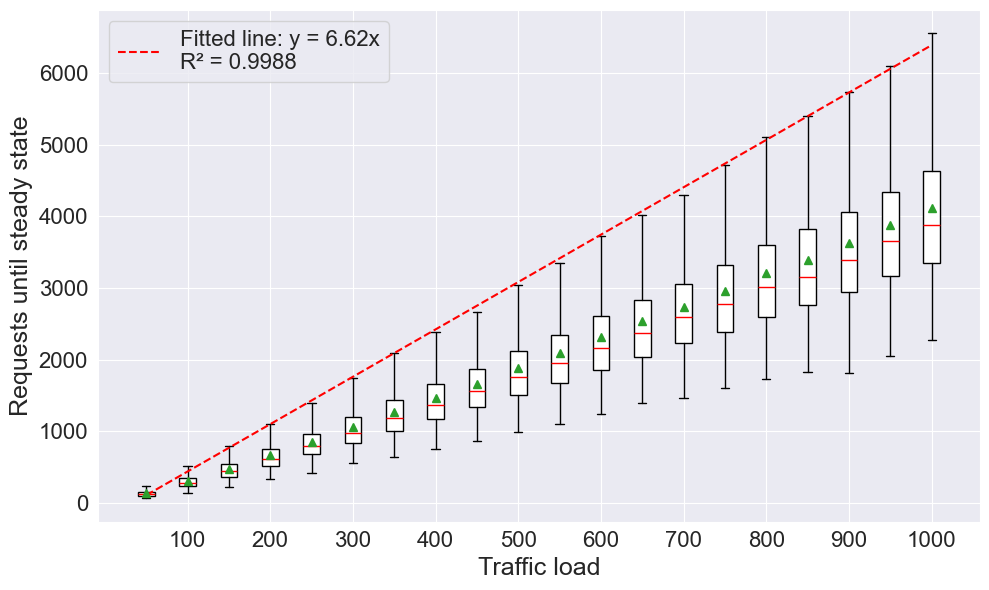

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Get series of num_requests for each load
requests = [df[df["load"] == load]["num_requests"] for load in sorted(df["load"].unique())]
loads = sorted(df["load"].unique())

# Create box plot
bp = ax.boxplot(requests, positions=loads, widths=20, patch_artist=True, showfliers=False, showmeans=True)

# Customize box appearance
for box in bp['boxes']:
    box.set(facecolor='white', edgecolor='black')
for whisker in bp['whiskers']:
    whisker.set(color='black')
for cap in bp['caps']:
    cap.set(color='black')
for median in bp['medians']:
    median.set(color='red')

# Extract upper whisker values
upper_whiskers = [item.get_ydata()[1] for item in bp['whiskers'][1::2]]

# Fit a line to the upper whiskers
coeffs = np.polyfit(loads, upper_whiskers, 1)
print(coeffs)
poly = np.poly1d(coeffs)

# Calculate R-squared
y_pred = poly(loads)
y_mean = np.mean(upper_whiskers)
ss_tot = np.sum((upper_whiskers - y_mean)**2)
ss_res = np.sum((upper_whiskers - y_pred)**2)
r_squared = 1 - (ss_res / ss_tot)

# Plot the fitted line with R-squared in the label
label = f'Fitted line: y = {coeffs[0]:.2f}x {"+" if coeffs[1]>0 else "-"} {abs(coeffs[1]):.0f}\nR² = {r_squared:.4f}'
label = f'Fitted line: y = {coeffs[0]:.2f}x\nR² = {r_squared:.4f}'
ax.plot(loads, poly(loads), color='r', linestyle='--', label=label)

ax.set_xlabel("Traffic load (Erlang)", size=18)
ax.set_ylabel("Requests until steady state", size=18)
ax.legend(fontsize=16)
plt.xticks(size=16)
plt.yticks(size=16)

# Set x-axis ticks to show load/100
ax.set_xticks(loads[1::2])  # Show every other tick to avoid crowding
ax.set_xticklabels([f'{load:.0f}' for load in loads[1::2]])

plt.tight_layout()
plt.savefig("steady_state_boxplots.png")
plt.show()

# The second method is the MSER-5 method of warm-up period estimation

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def mser_batch(data, m, true_mean=None):
    n = len(data)
    if n < 2*m: return 0  # Need at least 2 batches
    
    # Create batches of size 5
    num_batches = n // m
    batched_means = np.array([np.mean(data[i:i+m]) for i in range(0, num_batches*m, m)])
    
    mser_values = []
    for d in range(len(batched_means)):
        remaining = batched_means[d:]
        if len(remaining) < 2: break
        grand_mean = true_mean if true_mean else np.mean(remaining)
        r = len(remaining)
        mser = np.sum((remaining - grand_mean)**2) / (r * (r-1))
        mser_values.append(mser)
        
    return np.argmin(mser_values) * m if mser_values else 0

batch_size = 5

results = []
for repeats in range(500):
   for load in np.arange(50,1050,50):
       num_requests = load * 10
       for arrival_rate in [5, 10, 15, 20, 25]:
           mean_service_holding_time = load/arrival_rate
           services = []
           active_services = []
           active_services_history = []
           current_time = 0
           for i in range(num_requests):
               current_time += np.random.exponential(1/arrival_rate)
               holding_time = np.random.exponential(mean_service_holding_time)
               services.append(current_time + holding_time)
               active_services = [x for x in services if x > current_time]
               active_services_history.append(len(active_services))
           truncation_point = mser_batch(active_services_history, batch_size, true_mean=load)
           results.append({
               "arrival_rate": arrival_rate,
               "mean_service_holding_time": mean_service_holding_time,
               "load": load,
               "current_time": current_time,
               "active_services": len(active_services),
               "truncation_point": truncation_point,
           })

df2 = pd.DataFrame(results)
df2

,arrival_rate,mean_service_holding_time,load,current_time,active_services,truncation_point
0,5,10.000000,50,107.933092,44,140
1,10,5.000000,50,53.685401,53,235
2,15,3.333333,50,34.284292,63,120
3,20,2.500000,50,24.973647,75,60
4,25,2.000000,50,18.858518,49,50
...,...,...,...,...,...,...
49995,5,200.000000,1000,1993.932803,1046,4330
49996,10,100.000000,1000,994.486796,1000,5420
49997,15,66.666667,1000,659.091294,1086,5100
49998,20,50.000000,1000,486.777938,1039,2800


[  8.73586466 -79.57894737]


OSError: 'white_background' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

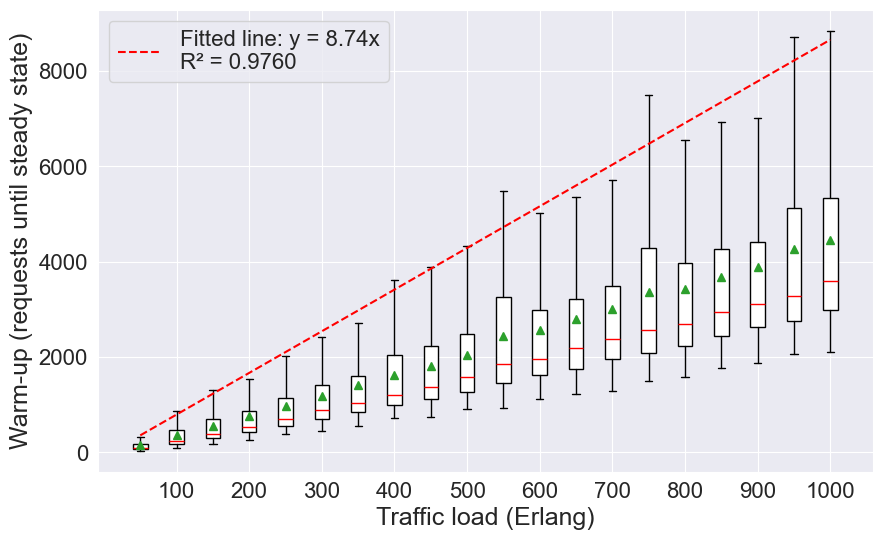

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

# Get series of num_requests for each load
requests = [df[df["load"] == load]["truncation_point"] for load in sorted(df["load"].unique())]
loads = sorted(df["load"].unique())

# Create box plot
bp = ax.boxplot(requests, positions=loads, widths=20, patch_artist=True, showfliers=False, showmeans=True)

# Customize box appearance
for box in bp['boxes']:
    box.set(facecolor='white', edgecolor='black')
for whisker in bp['whiskers']:
    whisker.set(color='black')
for cap in bp['caps']:
    cap.set(color='black')
for median in bp['medians']:
    median.set(color='red')

# Extract upper whisker values
upper_whiskers = [item.get_ydata()[1] for item in bp['whiskers'][1::2]]

# Fit a line to the upper whiskers
coeffs = np.polyfit(loads, upper_whiskers, 1)
print(coeffs)
poly = np.poly1d(coeffs)

# Calculate R-squared
y_pred = poly(loads)
y_mean = np.mean(upper_whiskers)
ss_tot = np.sum((upper_whiskers - y_mean)**2)
ss_res = np.sum((upper_whiskers - y_pred)**2)
r_squared = 1 - (ss_res / ss_tot)

# Plot the fitted line with R-squared in the label
label = f'Fitted line: y = {coeffs[0]:.2f}x {"+" if coeffs[1]>0 else "-"} {abs(coeffs[1]):.0f}\nR² = {r_squared:.4f}'
label = f'Fitted line: y = {coeffs[0]:.2f}x\nR² = {r_squared:.4f}'
ax.plot(loads, poly(loads), color='r', linestyle='--', label=label)

ax.set_xlabel("Traffic load (Erlang)", size=18)
ax.set_ylabel("Warm-up (requests until steady state)", size=18)
ax.legend(fontsize=16)
plt.xticks(size=16)
plt.yticks(size=16)

# Set x-axis ticks to show load/100
ax.set_xticks(loads[1::2])  # Show every other tick to avoid crowding
ax.set_xticklabels([f'{load:.0f}' for load in loads[1::2]])

# Make the background white
plt.style.use('white_background')

plt.tight_layout()
plt.savefig("steady_state_boxplots.png")
plt.show()